<a href="https://colab.research.google.com/github/ZPavlo/ML_projects/blob/master/object_detecion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
PATH = "/content/gdrive/My Drive"

In this project I am create deep model to solve the object detection task. 

Base: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection.git

# Dataset review

The first step in desiging any model is to find training data. In this task I use VOC dataset for Object detection task.

In [0]:
# Label map
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

# Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [4]:
import os 
import cv2
import numpy as np
import torch
from torchvision.datasets.voc import VOCDetection
import torchvision.transforms as transforms
import torchvision.transforms.functional as func

ROOT_PATH = os.path.join(PATH, "datasets")

train_dataset = VOCDetection(ROOT_PATH, image_set="train", download=False)
val_dataset = VOCDetection(ROOT_PATH, image_set="val", download=False)
print("train:", len(train_dataset)) # 5717
print("val:", len(val_dataset)) # 5823

train: 5717
val: 5823


In [0]:
BATCH_SIZE = 8

In [0]:
from torch.utils.data import DataLoader

def collate_fn(samples):

    images = []
    sizes = []
    boxes_batch = []
    labels_batch = []
    diffs_batch = []

    for (img, target) in samples:
        
        annotation = target["annotation"]
        boxes_dict = annotation["object"]

        if isinstance(boxes_dict, dict):
            boxes_dict = [boxes_dict]
        size = annotation["size"]
        size = (int(size["depth"]), int(size["height"]), int(size["width"]))
        
        boxes = []
        labels = []
        difficult = []
        for box in boxes_dict:
            boxes.append([float(box["bndbox"]["xmin"]), float(box["bndbox"]["ymin"]),
                          float(box["bndbox"]["xmax"]), float(box["bndbox"]["ymax"])])
            labels.append(label_map[box["name"]])
            difficult.append(int(box["difficult"]))

        boxes = torch.FloatTensor(boxes)
        
        labels = torch.LongTensor(labels)
        difficult = torch.LongTensor(difficult)

        images.append(img)
        boxes_batch.append(boxes)
        sizes.append(size)
        labels_batch.append(labels)
        diffs_batch.append(difficult)

    return {"img": images,
            "boxes": boxes_batch,
            "size": sizes,
            "labels": labels_batch,
            "difficult": diffs_batch
            }

train_load = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                        num_workers=0, pin_memory=True, 
                        collate_fn=collate_fn)
val_load = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        num_workers=0, pin_memory=True)

In [0]:
batch = next(iter(train_load))


In [0]:
def resize(image, boxes):
    DIM = (300, 300)
    boxes = boxes.clone()
    w, h = image.size
    image = func.resize(image, DIM)

    boxes[:, 0] = boxes[:, 0] * (DIM[0] / float(w))
    boxes[:, 1] = boxes[:, 1] * (DIM[1] / float(h))
    boxes[:, 2] = boxes[:, 2] * (DIM[0] / float(w))
    boxes[:, 3] = boxes[:, 3] * (DIM[1] / float(h))
  
    return image, boxes

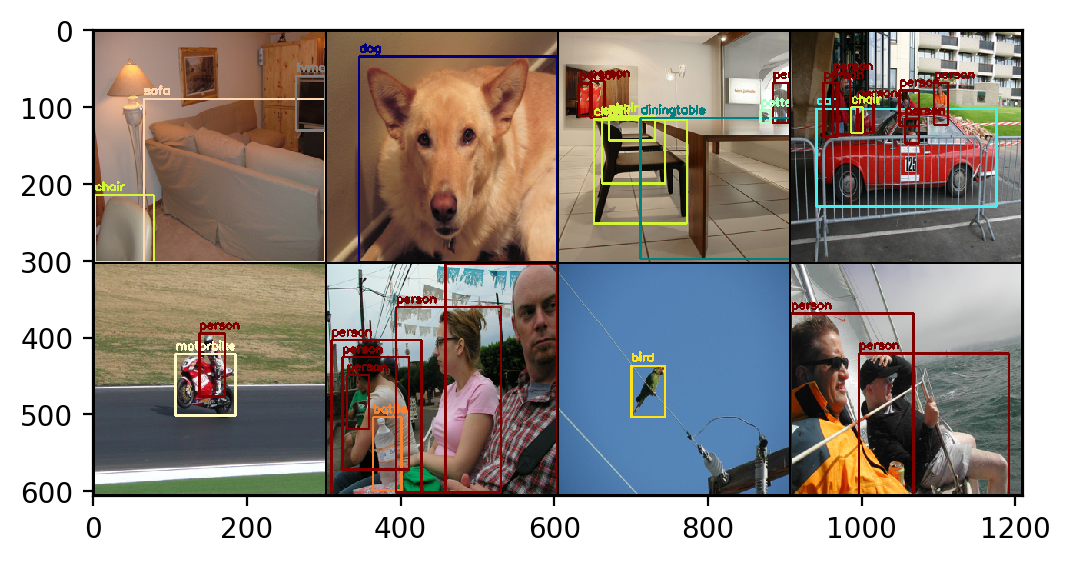

In [9]:
import torchvision.utils as utils
import torch
import matplotlib.pyplot as plt

def draph_boxes(image, objs, labels):
  
    image = np.array(image)

    for (box, l) in zip(objs, labels):
        l = int(l)
        name = rev_label_map[l]
        color = label_color_map[name].lstrip('#')
        color = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
        image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.putText(image, name, (int(box[0]), int(box[1]) - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return torch.from_numpy(np.transpose(image, (2, 0, 1)))

new_imgs = []
for i, img in enumerate(batch["img"]):
    new_im, boxes = resize(img, batch["boxes"][i])
    new_imgs.append(draph_boxes(new_im, boxes, batch["labels"][i]))

grid = utils.make_grid(new_imgs, 4, padding=2)
ngrid = grid.numpy()

plt.figure(dpi=200)
plt.imshow(np.transpose(ngrid, (1, 2, 0)))

Create different transformation function for object detection task

In [0]:
def flip(image, boxes):

    # Flip image
    # image = func.to_pil_image(image)
    new_image = func.hflip(image.copy())

    # Flip boxes
    new_boxes = boxes.clone()
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes

In [0]:
img = batch["img"][0]
boxes = batch["boxes"][0]
labels = batch["labels"][0]
difficult = batch["difficult"][0]
size = batch["size"][0]

In [0]:
def draph_img(img, boxes, labels):
    draw_img = draph_boxes(img, boxes, labels)
    plt.figure(dpi=150)
    plt.imshow(np.transpose(draw_img.numpy(), (1, 2, 0)))

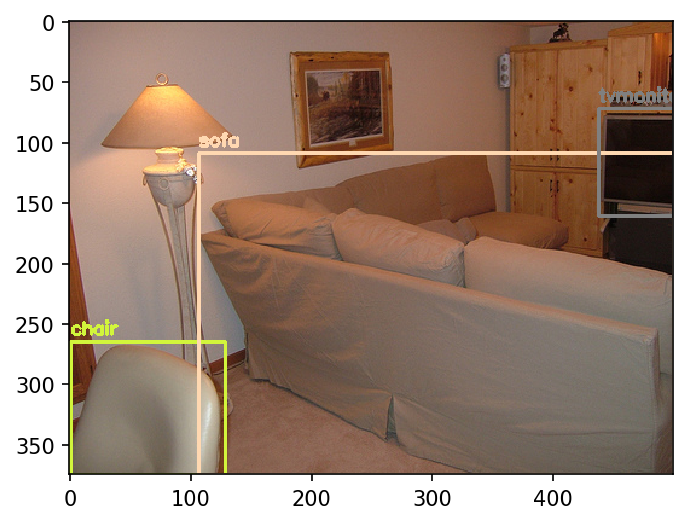

In [13]:
draph_img(img, boxes, labels)

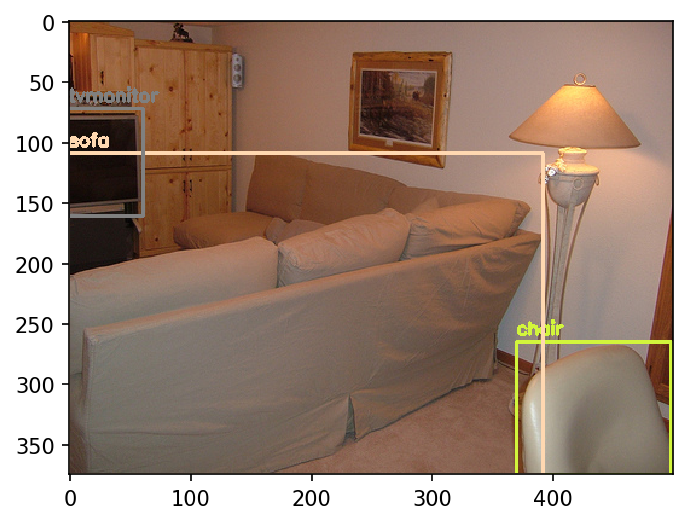

In [14]:
img_flip, boxes_flip = flip(img, boxes)

draph_img(img_flip, boxes_flip, labels)

In [0]:
import random

def photometric_distort(image):
  
    new_image = image

    distortions = [func.adjust_brightness,
                   func.adjust_contrast,
                   func.adjust_saturation,
                   func.adjust_hue]

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ is 'adjust_hue':                
                adjust_factor = random.uniform(-18 / 255., 18 / 255.)
            else:              
                adjust_factor = random.uniform(0.5, 1.5)
            
            new_image = d(new_image, adjust_factor)

    return new_image

<class 'PIL.Image.Image'>


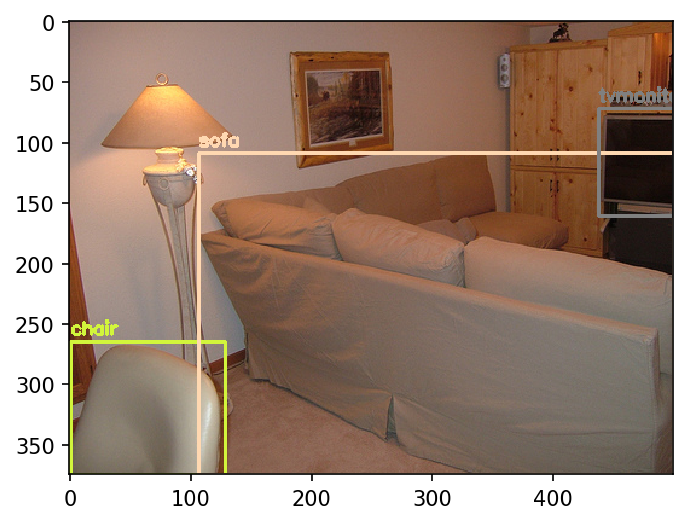

In [16]:
img_dist = photometric_distort(img)
print(type(img_dist))
draph_img(img_dist, boxes, labels)

In [17]:
torch.from_numpy(np.array(img)).shape

torch.Size([375, 500, 3])

In [0]:
def find_iou(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

def random_crop(image, boxes, labels, difficulties):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.
    Note that some objects may be cut out entirely.
    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels, updated difficulties
    """

    boxes = boxes.clone()
    labels = labels.clone()
    difficulties = difficulties.clone()

    original_h = image.shape[1]
    original_w = image.shape[2]
  
    while True:
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes, labels, difficulties

        max_trials = 50
        for _ in range(max_trials):
          
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_iou(crop.unsqueeze(0), boxes) 
            overlap = overlap.squeeze(0)  # (n_objects)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image

            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                    bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]
            new_difficulties = difficulties[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels, new_difficulties

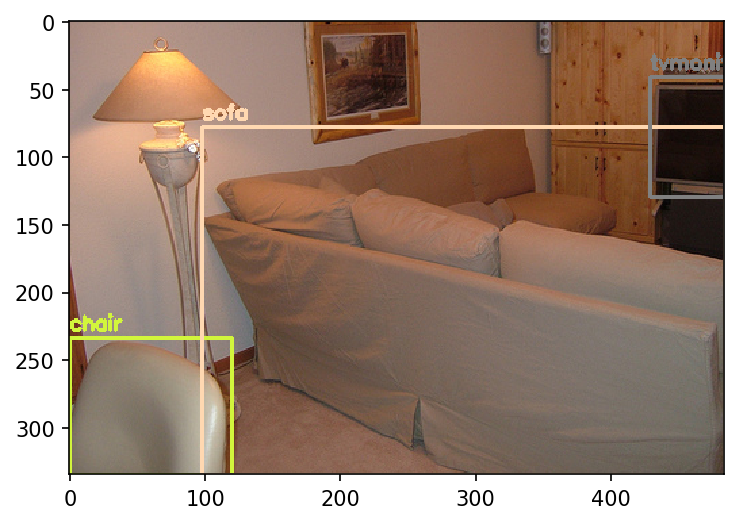

In [19]:
img_crop = func.to_tensor(img)
img_crop, boxes_crop, labels_crop, difficult_crop = random_crop(img_crop, boxes, labels, difficult)
img_crop = func.to_pil_image(img_crop)

draph_img(img_crop, boxes_crop, labels_crop)

In [0]:
def transform(image, boxes, labels, difficulties, split, not_percent=False):

    assert split in {'TRAIN', 'TEST', 'VAL'}

    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    DIM = (300, 300)

    new_image = image
    new_boxes = boxes.clone()
    new_labels = labels.clone()
    new_difficulties = difficulties.clone()

    if split in ['TRAIN', 'VAL']:
        new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = func.to_tensor(new_image)

        new_image, new_boxes, new_labels, new_difficulties = random_crop(new_image, new_boxes, new_labels,
                                                                         new_difficulties)

        # Convert Torch tensor to PIL image
        new_image = func.to_pil_image(new_image)

        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    w, h = new_image.size
    new_image = func.resize(new_image, DIM)

    new_boxes[:, 0] = new_boxes[:, 0] / float(w)
    new_boxes[:, 1] = new_boxes[:, 1] / float(h)
    new_boxes[:, 2] = new_boxes[:, 2] / float(w)
    new_boxes[:, 3] = new_boxes[:, 3] / float(h)

    if not_percent:
        new_boxes[:, 0] = new_boxes[:, 0] * DIM[0] 
        new_boxes[:, 1] = new_boxes[:, 1] * DIM[1]
        new_boxes[:, 2] = new_boxes[:, 2] * DIM[0]
        new_boxes[:, 3] = new_boxes[:, 3] * DIM[1]

    new_image = func.to_tensor(new_image)
    new_image = func.normalize(new_image, mean=MEAN, std=STD)

    return new_image, new_boxes, new_labels, new_difficulties

torch.Size([3, 300, 300])
torch.Size([1, 4])
torch.Size([1])
torch.Size([1])


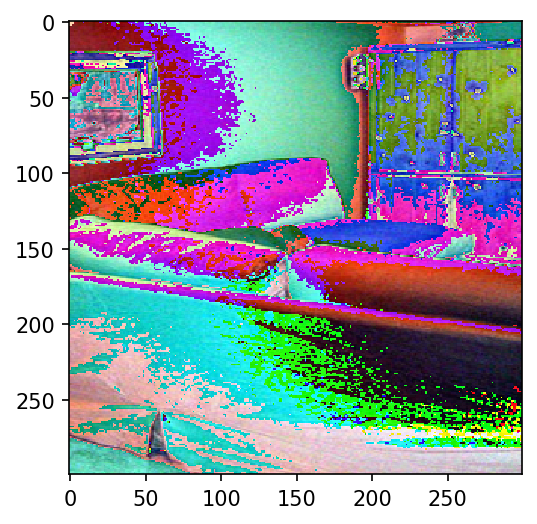

In [21]:
new_image, new_boxes, new_labels, new_difficulties = transform(img, boxes, labels, difficult, "TRAIN")

print(new_image.shape)
print(new_boxes.shape)
print(new_labels.shape)
print(new_difficulties.shape)

d_img = func.to_pil_image(new_image)

draph_img(d_img, new_boxes, new_labels)

In [0]:
def collate_fn(samples):

    images = []
    sizes = []
    boxes_batch = []
    labels_batch = []
    diffs_batch = []

    for (img, target) in samples:
        
        annotation = target["annotation"]
        boxes_dict = annotation["object"]

        if isinstance(boxes_dict, dict):
            boxes_dict = [boxes_dict]
        size = annotation["size"]
        size = (int(size["depth"]), int(size["height"]), int(size["width"]))
        
        boxes = []
        labels = []
        difficult = []
        for box in boxes_dict:
            boxes.append([float(box["bndbox"]["xmin"]), float(box["bndbox"]["ymin"]),
                          float(box["bndbox"]["xmax"]), float(box["bndbox"]["ymax"])])
            labels.append(label_map[box["name"]])
            difficult.append(int(box["difficult"]))

        boxes = torch.FloatTensor(boxes)
        
        labels = torch.LongTensor(labels)
        difficult = torch.LongTensor(difficult)

        images.append(img)
        boxes_batch.append(boxes)
        sizes.append(size)
        labels_batch.append(labels)
        diffs_batch.append(difficult)

    return {"img": images,
            "boxes": boxes_batch,
            "size": sizes,
            "labels": labels_batch,
            "difficult": diffs_batch
            }


train_dataset = VOCDetection(ROOT_PATH, image_set="train", download=False)

train_load_full = DataLoader(train_dataset, batch_size=8, shuffle=True, 
                        num_workers=2, pin_memory=True, 
                        collate_fn=collate_fn)

([<matplotlib.axis.XTick at 0x7f9e45909470>,
 <a list of 3 Text xticklabel objects>)

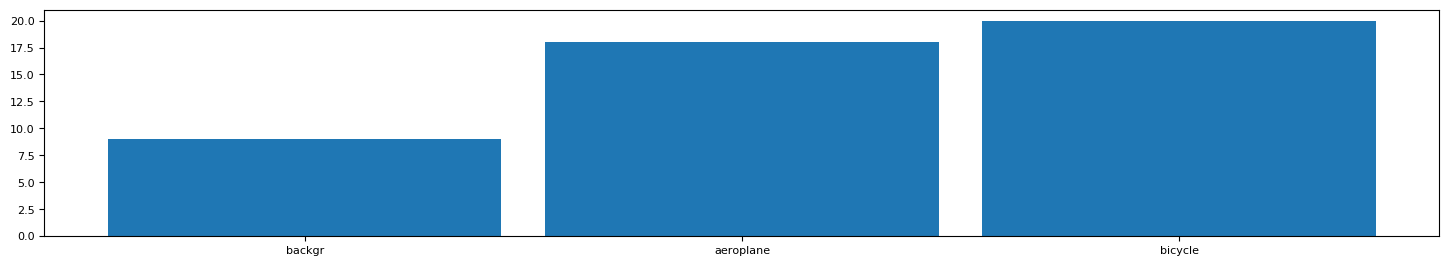

In [23]:
from tqdm import tqdm

# Showing class imbalange
num_classes = len(voc_labels) + 1

# labels = torch.zeros(num_classes)
# for batch in tqdm(train_load_full):
#     for l in batch["labels"]:
#         labels +=  torch.bincount(l, minlength=num_classes)
# print(labels)

x = np.arange(labels.shape[0])
plt.figure(dpi=100, figsize=(18, 3))
plt.rcParams.update({'font.size': 8})
plt.bar(x, height=labels.numpy(), width=0.9)
plt.xticks(x, ["backgr"] + list(voc_labels))

([<matplotlib.axis.XTick at 0x7f9e41f300b8>,
 <a list of 3 Text xticklabel objects>)

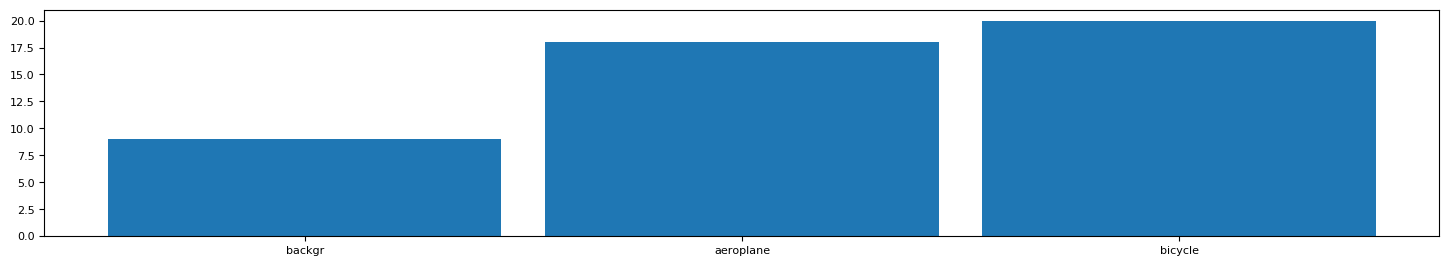

In [24]:
x = np.arange(labels.shape[0])
plt.figure(dpi=100, figsize=(18, 3))
plt.rcParams.update({'font.size': 8})
plt.bar(x, height=labels.numpy(), width=0.9)
plt.xticks(x, ["backgr"] + list(voc_labels))

In [0]:
import torch

class MyVOCDetection(VOCDetection):

    def __init__(self, root, download=False, transforms=None, split="TRAIN"):
      super(MyVOCDetection, self).__init__(root, image_set=split.lower(), download=download)
      
      self.my_transforms = transforms
      self.split = split

    def __getitem__(self, index):
      img, target = super().__getitem__(index)

      annotation = target["annotation"]
      boxes_dict = annotation["object"]

      if isinstance(boxes_dict, dict):
        boxes_dict = [boxes_dict]
      size = annotation["size"]
      size = (int(size["depth"]), int(size["height"]), int(size["width"]))
      
      boxes = []
      labels = []
      difficult = []
      for box in boxes_dict:
          boxes.append([float(box["bndbox"]["xmin"]), float(box["bndbox"]["ymin"]),
                        float(box["bndbox"]["xmax"]), float(box["bndbox"]["ymax"])])
          labels.append(label_map[box["name"]])
          difficult.append(int(box["difficult"]))

      boxes = torch.FloatTensor(boxes)
      labels = torch.LongTensor(labels)
      difficult = torch.LongTensor(difficult)
      
      if self.my_transforms is not None:
          img, boxes, labels, difficult = self.my_transforms(img, boxes, labels, difficult, self.split)

      return (img, 
              size, 
              boxes, 
              labels,
              difficult
              )
      
    def collate_fn(self, samples):

      images = []
      sizes = []
      boxes_batch = []
      labels_batch = []
      diffs_batch = []

      for (img, size, boxes, lab, dif) in samples:
          
          images.append(img)
          boxes_batch.append(boxes)
          sizes.append(size)
          labels_batch.append(lab)
          diffs_batch.append(dif)

      images = torch.stack(images)
      
      return {"img": images,
              "boxes": boxes_batch,
              "size": sizes,
              "labels": labels_batch,
              "difficult": diffs_batch
              }

# Create model

In [0]:
import numpy as np
import math


def create_prior_boxes():

    prior_boxes = []

    for k, fmap in enumerate(fmaps):
        f_size = fmap_dims[fmap]

        cx = (np.arange(f_size) + 0.5) / f_size
        cy = (np.arange(f_size) + 0.5) / f_size
        x_grad, y_grad = np.meshgrid(cx, cy)

        for ratio in aspect_ratios[fmap]:

            w = np.ones_like(x_grad) * obj_scales[fmap] * math.sqrt(ratio)
            h = np.ones_like(x_grad) * obj_scales[fmap] / math.sqrt(ratio)

            anchors = np.stack([x_grad, y_grad, w, h], axis=-1).reshape(-1, 4)
            prior_boxes.append(anchors)
            
            if ratio == 1.:
                try:
                    ad = math.sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                except IndexError:
                    ad = 1.
                a = np.ones_like(x_grad) * ad
                anchors = np.stack([x_grad, y_grad, a, a], axis=-1).reshape(-1, 4)
                prior_boxes.append(anchors)

    prior_boxes = np.concatenate(prior_boxes, axis=0).astype("float32")
    return prior_boxes

In [0]:
from torchvision.models import vgg16
import torch.nn as nn

class VGG_Mode(nn.Module):
    
    def __init__(self):
        super(VGG_Mode, self).__init__()

        self.vgg = vgg16(pretrained=False)
        # Change model
        # 3-th MaxPool (add ceil_mode=True => 37x37 -> 38x38)
        self.vgg.features[16] = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        # 5-th MaxPool
        self.vgg.features[30] = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.vgg.features1 = self.vgg.features[:23]
        self.vgg.features2 = self.vgg.features[23:]
        
        # Replace FC -> Conv
        self.vgg.classifier = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(True),
            nn.Conv2d(1024, 1024, kernel_size=1),
            nn.ReLU(True)
        )

    def forward(self, x):

        x = self.vgg.features1(x)
        out4_3 = x
        x = self.vgg.features2(x)
        out7 = self.vgg.classifier(x)

        return out4_3, out7

In [0]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        self.conv8 = nn.Sequential(nn.Conv2d(1024, 256, kernel_size=1, padding=0),
                                   nn.ReLU(True),
                                   nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                                   nn.ReLU(True))

        self.conv9 = nn.Sequential(nn.Conv2d(512, 128, kernel_size=1, padding=0),
                                   nn.ReLU(True),
                                   nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                                   nn.ReLU(True))

        self.conv10 = nn.Sequential(nn.Conv2d(256, 128, kernel_size=1, padding=0),
                                    nn.ReLU(True),
                                    nn.Conv2d(128, 256, kernel_size=3, padding=0),
                                    nn.ReLU(True))
        
        self.conv11 = nn.Sequential(nn.Conv2d(256, 128, kernel_size=1, padding=0),
                                    nn.ReLU(True),
                                    nn.Conv2d(128, 256, kernel_size=3, padding=0),
                                    nn.ReLU(True))
  
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for seq in self.children():
          for c in seq.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):

        out = self.conv8(conv7_feats)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = self.conv9(out)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = self.conv10(out)
        conv10_2_feats = out  # (N, 256, 3, 3)

        conv11_2_feats = self.conv11(out)# (N, 256, 1, 1)

        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

In [0]:
class PredictionConvolutions(nn.Module):

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
 
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):

        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores


In [0]:
class SSD300(nn.Module):

    def __init__(self, n_classes, min_score, max_overlap, top_k):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGG_Mode()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = torch.from_numpy(create_prior_boxes()).cuda()

        self.min_score = min_score
        self.max_overlap = max_overlap
        self.top_k = top_k


    def forward(self, image, split="TRAIN"):
        
        assert split in {'TRAIN', 'TEST', 'VAL'}

        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,
                                               conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        if split in {"TRAIN", "VAL"}:
            return locs, classes_scores
        else: 
            return self.detect_objects(locs, classes_scores, self.min_score, self.max_overlap, self.top_k)

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):

        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_iou(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).cuda()  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).cuda())
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).cuda())
                image_labels.append(torch.LongTensor([0]).cuda())
                image_scores.append(torch.FloatTensor([0.]).cuda())

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

In [0]:
def xy_to_cxcy(xy):
    """
    Convert  (x_min, y_min, x_max, y_max) to  (c_x, c_y, w, h).
    :param xy: bounding boxes in boundary coordinates(n_boxes, 4)
    :return: bounding boxes in center-size coordinates(n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], dim=1)  # w, h


def cxcy_to_xy(cxcy):
    """
    Convert (c_x, c_y, w, h) to  (x_min, y_min, x_max, y_max).
    :param cxcy: bounding boxes in center-size coordinates(n_boxes, 4)
    :return: bounding boxes in boundary coordinates(n_boxes, 4)
    """
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], dim=1)  # x_max, y_max


def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).
    :param cxcy: bounding boxes (n_priors, 4)
    :param priors_cxcy: prior boxes (n_priors, 4)
    :return: encoded bounding boxes (n_priors, 4)
    """

    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], dim=1)  # g_w, g_h


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    """
    Decode bounding box coordinates predicted by the model, since they are encoded in the form mentioned above.
    :param gcxgcy: encoded bounding boxes(n_priors, 4)
    :param priors_cxcy: prior boxes (n_priors, 4)
    :return: decoded bounding boxes(n_priors, 4)
    """

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], dim=1)  # w, h

class MultiBoxLoss(nn.Module):

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
    
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):

        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).cuda()  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).cuda()  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_iou(boxes[i], self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).cuda()
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # CONFIDENCE LOSS

        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)
    

        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), 
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).cuda() # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)

        conf_loss = 0.0
        for i in range(batch_size):
            neg = hard_negatives[i]
            tr = positive_priors[i]
            conf_loss += (conf_loss_all[i, tr].sum() + conf_loss_neg[i, neg].sum()) / n_positives[i]
        
        conf_loss

        # TOTAL LOSS    

        return conf_loss / batch_size + self.alpha * loc_loss


In [0]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [0]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer, loss, best_loss, is_best):
    optim_state = optimizer.state_dict() if optimizer is not None else None

    state = {'epoch': epoch,
             'best_loss':best_loss,
             'model': model.state_dict(),
             'optimizer': optim_state}

    filename = 'checkpoint_ssd300_ep_{}.pth.tar'.format(epoch)
    torch.save(state, filename)
    print("Save epoch: {}".format(epoch))
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)
        print("Save BEST epoch: {}".format(epoch))
    
def load_checkpoint(model, optimizer, path):

    checkpoint = torch.load(path)
    start_epoch = checkpoint['epoch'] + 1
    # best_loss = checkpoint['best_loss']

    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    return start_epoch, best_loss

In [0]:

fmap_dims = {'conv4_3': 38,
            'conv7': 19,
            'conv8_2': 10,
            'conv9_2': 5,
            'conv10_2': 3,
            'conv11_2': 1}

obj_scales = {'conv4_3': 0.1,
            'conv7': 0.2,
            'conv8_2': 0.375,
            'conv9_2': 0.55,
            'conv10_2': 0.725,
            'conv11_2': 0.9}

aspect_ratios = {'conv4_3': [1., 2., 0.5],
                'conv7': [1., 2., 3., 0.5, .333],
                'conv8_2': [1., 2., 3., 0.5, .333],
                'conv9_2': [1., 2., 3., 0.5, .333],
                'conv10_2': [1., 2., 0.5],
                'conv11_2': [1., 2., 0.5]}

fmaps = list(fmap_dims.keys())

n_boxes = {f:len(aspect_ratios[f])+1 for f in fmaps}

BATCH_SIZE = 8
EPOCHS = 200
WORKERS = 2
PRINT_FREQ = 150

LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

MIN_SCORE = 0.01
MAX_OVERLAP = 0.45
TOP_K = 200

In [41]:
net = SSD300(n_classes=len(label_map), min_score=MIN_SCORE, 
             max_overlap=MAX_OVERLAP, top_k=TOP_K)

if torch.cuda.is_available():
    net.cuda()
    print("Cuda")
else:
    print("NO Cuda")

Cuda


In [0]:
train_dataset = MyVOCDetection(ROOT_PATH, split="TRAIN", transforms=transform)
val_dataset = MyVOCDetection(ROOT_PATH, split="VAL", transforms=transform)

train_load = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                        num_workers=2, pin_memory=True, 
                        collate_fn=train_dataset.collate_fn)
val_load = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                        num_workers=2, pin_memory=True, 
                        collate_fn=val_dataset.collate_fn)

In [43]:
biases = list()
not_biases = list()
for param_name, param in net.named_parameters():
    if param.requires_grad:
        if param_name.endswith('.bias'):
            biases.append(param)
        else:
            not_biases.append(param)
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * LR}, {'params': not_biases, 'lr': LR}],
                            momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

criterion = MultiBoxLoss(priors_cxcy=net.priors_cxcy).cuda()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [0]:
from tqdm import tqdm
import time

def train_epoch(net, dataloader, criterion, optimizer, epoch):

    net.train() 
    
    batch_time = AverageMeter()
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()

    start = time.time()

    for i, data in enumerate(dataloader):
        data_time.update(time.time() - start)

        optimizer.zero_grad()

        images = data["img"].cuda()
        boxes = [b.cuda() for b in data["boxes"]]
        labels = [l.cuda() for l in data["labels"]]

        predicted_locs, predicted_scores = net(images)
        
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)

        losses.update(float(loss), images.size(0))
        batch_time.update(time.time() - start)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        if (i+1) % PRINT_FREQ == 0:
            print('[{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'.format(epoch, i, len(dataloader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
        start = time.time()

def validate(dataloader, net, criterion):

    net.eval()  # eval mode disables dropout

    batch_time = AverageMeter()
    losses = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i, data in enumerate(dataloader):

            images = data["img"].cuda()
            boxes = [b.cuda() for b in data["boxes"]]
            labels = [l.cuda() for l in data["labels"]]

            # Forward prop.
            predicted_locs, predicted_scores = net(images)  # (N, 8732, 4), (N, 8732, n_classes)

            # Loss
            loss = criterion(predicted_locs, predicted_scores, boxes, labels)

            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()

            # Print status
            if i % PRINT_FREQ == 0:
                print('[{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(i, len(dataloader),
                                                                      batch_time=batch_time,
                                                                      loss=losses))

    print('\n * LOSS - {loss.avg:.3f}\n'.format(loss=losses))

    return losses.avg


In [45]:
PRINT_FREQ=1

for i in range(1000):
    train_epoch(net, train_load, criterion, optimizer, i)

Epoch: [0][0/715]	Loss 18.9750 (18.9750)	Batch Time 2.173 (2.173)	Data Time 1.981 (1.981)	
Epoch: [1][0/715]	Loss 15.7713 (15.7713)	Batch Time 1.018 (1.018)	Data Time 0.896 (0.896)	
Epoch: [2][0/715]	Loss 13.6411 (13.6411)	Batch Time 1.024 (1.024)	Data Time 0.833 (0.833)	
Epoch: [3][0/715]	Loss 14.6539 (14.6539)	Batch Time 0.453 (0.453)	Data Time 0.327 (0.327)	
Epoch: [4][0/715]	Loss 14.0314 (14.0314)	Batch Time 1.558 (1.558)	Data Time 1.363 (1.363)	
Epoch: [5][0/715]	Loss 15.8088 (15.8088)	Batch Time 1.422 (1.422)	Data Time 1.242 (1.242)	
Epoch: [6][0/715]	Loss 14.3500 (14.3500)	Batch Time 1.531 (1.531)	Data Time 1.384 (1.384)	
Epoch: [7][0/715]	Loss 13.5283 (13.5283)	Batch Time 2.276 (2.276)	Data Time 2.080 (2.080)	
Epoch: [8][0/715]	Loss 14.1776 (14.1776)	Batch Time 1.420 (1.420)	Data Time 1.296 (1.296)	
Epoch: [9][0/715]	Loss 16.0618 (16.0618)	Batch Time 0.667 (0.667)	Data Time 0.474 (0.474)	
Epoch: [10][0/715]	Loss 14.1306 (14.1306)	Batch Time 1.200 (1.200)	Data Time 1.008 (1.008)

KeyboardInterrupt: ignored